In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
data_burden = pd.read_csv('data.csv')
data_burden = data_burden[data_burden['burden'].notna()]
data_burden = data_burden[data_burden.columns[data_burden.isnull().mean() < 0.2]]

data_burden.columns[data_burden.isnull().any()]

for column in data_burden.columns:
    data_burden[column].fillna(data_burden[column].mode()[0], inplace=True)

median = data_burden.loc[data_burden['agecr'] < 200, 'agecr'].median()
data_burden["agecr"] = np.where(data_burden["agecr"] > 200, median,data_burden['agecr'])

# random forest
from sklearn.ensemble import RandomForestRegressor

X_feature = data_burden.drop('burden', axis = 1)
y_feature = data_burden['burden']

#m = sqrt(p)+1 features
nfeatures = data_burden.shape[1] - 1
feature_model = RandomForestRegressor(max_features = int(np.sqrt(nfeatures))+1, random_state = 1) #random_state ensure random bagging
feature_model.fit(X_feature,y_feature)


df_feature = pd.DataFrame(zip(X_feature.columns, feature_model.feature_importances_), columns = ['feature','importance'])
df_feature = df_feature.sort_values(by=['importance'], ascending=False)

df_feature[0:29]

,feature,importance
82,burdcat,0.200715
79,HOURS,0.141710
80,hourscat,0.139854
66,adls,0.106888
81,banhours,0.075357
78,Q25,0.062075
60,q22a,0.037226
61,q22b,0.033952
62,q22c,0.028694
63,q22d,0.021017


Text(0, 0.5, 'Features')

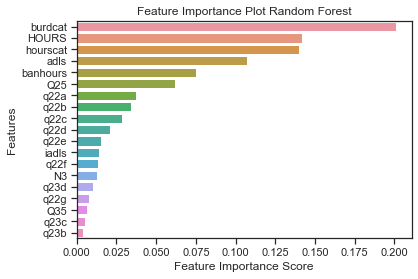

In [39]:
sns.barplot(data = df_feature[0:19], x = 'importance', y='feature', orient = 'h');
plt.title('Feature Importance Plot Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

In [40]:
#select the top few of the high important features while avoiding multi-colinearity
data_burden = data_burden[['year', 'Q18', 'HOURS', 'adls', 'q22a', 'q22b', 'q22d', 'N3', 'q22c', 'iadls', 'q22g', 'q22f', 'q23d', 'banlives', 'q23c', 'q22e', 'burden']]

In [41]:
#See the tally of data points of each of the illnesses
data_burden.groupby(['Q18'])['Q18'].count().sort_values(ascending=False)

Q18
24.0    486
23.0    256
3.0     255
14.0    226
32.0    213
22.0    165
19.0    138
30.0    134
8.0     130
16.0    126
18.0    126
33.0    118
13.0    101
20.0     99
43.0     98
34.0     93
5.0      85
10.0     79
21.0     73
27.0     54
11.0     46
12.0     37
7.0      33
31.0     30
39.0     23
40.0     21
15.0     20
1.0      13
44.0     12
36.0     10
26.0      8
17.0      8
37.0      8
6.0       8
9.0       4
42.0      4
28.0      3
35.0      3
29.0      2
38.0      2
2.0       1
4.0       1
Name: Q18, dtype: int64

In [42]:
#Select the only the ones with sufficient datapoints --- 80+ was arbitrarily chosen 
lst = [24.0, 3.0, 23.0, 32.0, 14.0, 22.0, 19.0, 30.0, 16.0, 8.0, 18.0, 5.0, 20.0, 13.0, 43.0]
data_burden = data_burden.loc[data_burden['Q18'].isin(lst)]
data_burden["Q18"] = data_burden["Q18"].astype(str)

#re-code the numbers to actual illness
data_burden["Q18"] = data_burden["Q18"].replace(["3.0","5.0","8.0","14.0","16.0","18.0","19.0","20.0","22.0","23.0","24.0","30.0","32.0"
                           , "13.0", '43.0'], ["Alzheimer","Arthritis", "BackProblems"
                           ,"Cancer", "Diabetes", "Falling", "HeartDisease",
                            "LungDisease", "MentalIllness", "MobilityProblem", "Aging",  "Stroke",
                            "Surgery", "BrokenBones", "Alzheimer"])
data_burden.head()

,year,Q18,HOURS,adls,q22a,q22b,q22d,N3,q22c,iadls,q22g,q22f,q23d,banlives,q23c,q22e,burden
3,2014,Aging,28.0,0.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,2.0,3.0
5,2014,MobilityProblem,0.5,4.0,1.0,1.0,2.0,1.0,2.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0
13,2014,Arthritis,77.0,0.0,2.0,2.0,2.0,1.0,2.0,5.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0
24,2014,Cancer,12.0,0.0,2.0,2.0,2.0,2.0,2.0,6.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0
36,2014,Diabetes,21.0,2.0,1.0,2.0,2.0,1.0,1.0,7.0,1.0,2.0,1.0,2.0,1.0,2.0,4.0


In [43]:
#Change the data types to categorical
lst2 = ['q22a', 'q22b', 'q22d', 'N3', 'q22c', 'q22g', 'q22f', 'q23d', 'banlives', 'q23c', 'q22e']
data_burden[lst2] = data_burden[lst2].astype(object)

In [44]:
#remove useless values such as "don't know", "not answered"

values = [3.0, 4.0]
data_burden = data_burden[
    (data_burden.q22a.isin(values) == False) \
        & (data_burden.q22b.isin(values) == False) \
        & (data_burden.q22d.isin(values) == False)
        & (data_burden.N3.isin(values) == False) \
        & (data_burden.q22c.isin(values) == False) \
        & (data_burden.q22g.isin(values) == False) \
        & (data_burden.q22f.isin(values) == False) \
        & (data_burden.q23d.isin(values) == False) \
        & (data_burden.q23c.isin(values) == False) \
        & (data_burden.q22e.isin(values) == False)                        
                        ]

data_burden = data_burden[data_burden['banlives'] != 3.0]

In [45]:
data_burden.head()

,year,Q18,HOURS,adls,q22a,q22b,q22d,N3,q22c,iadls,q22g,q22f,q23d,banlives,q23c,q22e,burden
3,2014,Aging,28.0,0.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0,1.0,1.0,1.0,2.0,3.0
5,2014,MobilityProblem,0.5,4.0,1.0,1.0,2.0,1.0,2.0,6.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0
13,2014,Arthritis,77.0,0.0,2.0,2.0,2.0,1.0,2.0,5.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0
24,2014,Cancer,12.0,0.0,2.0,2.0,2.0,2.0,2.0,6.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0
36,2014,Diabetes,21.0,2.0,1.0,2.0,2.0,1.0,1.0,7.0,1.0,2.0,1.0,2.0,1.0,2.0,4.0


In [46]:
#re-coding survey numbers to actual response
data_burden["q22a"] = data_burden["q22a"].astype(str)
data_burden["q22a"] = data_burden["q22a"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q22b"] = data_burden["q22b"].astype(str)
data_burden["q22b"] = data_burden["q22b"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q22d"] = data_burden["q22d"].astype(str)
data_burden["q22d"] = data_burden["q22d"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["N3"] = data_burden["N3"].astype(str)
data_burden["N3"] = data_burden["N3"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q22c"] = data_burden["q22c"].astype(str)
data_burden["q22c"] = data_burden["q22c"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q22g"] = data_burden["q22g"].astype(str)
data_burden["q22g"] = data_burden["q22g"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q22f"] = data_burden["q22f"].astype(str)
data_burden["q22f"] = data_burden["q22f"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q23d"] = data_burden["q23d"].astype(str)
data_burden["q23d"] = data_burden["q23d"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q23c"] = data_burden["q23c"].astype(str)
data_burden["q23c"] = data_burden["q23c"].replace(["1.0","2.0"], ["Yes","No"])
data_burden["q22e"] = data_burden["q22e"].astype(str)
data_burden["q22e"] = data_burden["q22e"].replace(["1.0","2.0"], ["Yes","No"])

data_burden["banlives"] = data_burden["banlives"].astype(str)
data_burden["banlives"] = data_burden["banlives"].replace(["1.0","2.0"], ["Yes","No"])

In [47]:
#renaming the column names to laymens terms
data_burden.columns = ['year', 'illness', 'hours', 'adls', 'help_with_bed', 'help_with_dressed', 'help_with_bathe', 'help_with_med', 'help_with_toilet', 'iadls', 'giving_medicine', 'help_with_feeding', 'preparing_meals', 'live_with_cr', 'help_housework', 'help_with_diapers', 'burden']
data_burden = data_burden.reset_index(drop=True)

## Plots

In [48]:
"""
df_1 = data_burden.groupby(['illness'])['burden'].median()
df_1 = df_1.to_frame()
df_1.reset_index(inplace=True)
df_1 = df_1.rename(columns = {'index':'illness'})
df_1['illness'] = df_1['illness'].astype(object)

fig = plt.figure(1, [20, 8])
fig.clf()

ax = fig.add_subplot(111)
ax.set_xlim(-1,14)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')
plt.bar(df_1['illness'],df_1['burden'])

plt.axhline(y=(df_1[df_1['illness'] == 'Aging']['burden'][0]),linewidth= 3, color='r', linestyle= 'dotted')
plt.title(label = "burden", fontsize=40)
plt.plot()
plt.show()
"""

'\ndf_1 = data_burden.groupby([\'illness\'])[\'burden\'].median()\ndf_1 = df_1.to_frame()\ndf_1.reset_index(inplace=True)\ndf_1 = df_1.rename(columns = {\'index\':\'illness\'})\ndf_1[\'illness\'] = df_1[\'illness\'].astype(object)\n\nfig = plt.figure(1, [20, 8])\nfig.clf()\n\nax = fig.add_subplot(111)\nax.set_xlim(-1,14)\nplt.setp(ax.get_xticklabels(), fontsize=10, rotation=\'vertical\')\nplt.bar(df_1[\'illness\'],df_1[\'burden\'])\n\nplt.axhline(y=(df_1[df_1[\'illness\'] == \'Aging\'][\'burden\'][0]),linewidth= 3, color=\'r\', linestyle= \'dotted\')\nplt.title(label = "burden", fontsize=40)\nplt.plot()\nplt.show()\n'

In [49]:
"""
sns.catplot(x="burden", y="help_with_diapers", kind="box", data=data_2014)
sns.catplot(x="help_with_diapers", y="burden", kind="box", data=data_2014)
"""

'\nsns.catplot(x="burden", y="help_with_diapers", kind="box", data=data_2014)\nsns.catplot(x="help_with_diapers", y="burden", kind="box", data=data_2014)\n'

In [50]:
data_burden.head()

,year,illness,hours,adls,help_with_bed,help_with_dressed,help_with_bathe,help_with_med,help_with_toilet,iadls,giving_medicine,help_with_feeding,preparing_meals,live_with_cr,help_housework,help_with_diapers,burden
0,2014,Aging,28.0,0.0,No,No,No,No,No,4.0,No,No,Yes,Yes,Yes,No,3.0
1,2014,MobilityProblem,0.5,4.0,Yes,Yes,No,Yes,No,6.0,Yes,Yes,Yes,No,Yes,Yes,3.0
2,2014,Arthritis,77.0,0.0,No,No,No,Yes,No,5.0,Yes,No,No,No,Yes,No,4.0
3,2014,Cancer,12.0,0.0,No,No,No,No,No,6.0,No,No,Yes,No,Yes,No,2.0
4,2014,Diabetes,21.0,2.0,Yes,No,No,Yes,Yes,7.0,Yes,No,Yes,No,Yes,No,4.0


In [51]:
"""
#sns.catplot(x="burden", y="hours", kind="box", data=data_burden)
sns.catplot(x="burden", y="hours", kind="violin", data=data_burden)

#sns.catplot(x="burden", y="iadls", kind="box", data=data_burden)
sns.catplot(x="burden", y="iadls", kind="violin", data=data_burden)

#sns.catplot(x="burden", y="adls", kind="box", data=data_burden)
sns.catplot(x="burden", y="adls", kind="violin", data=data_burden)

#sns.catplot(x="help_with_bed", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_with_bed", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="help_with_dressed", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_with_dressed", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="help_with_bathe", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_with_bathe", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="help_with_med", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_with_med", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="help_with_toilet", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_with_toilet", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="giving_medicine", y="burden", kind="box", data=data_burden)
sns.catplot(x="giving_medicine", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])
#sns.boxplot(x='species', y='sepal_length', data=df, order=["versicolor", "virginica", "setosa"])

#sns.catplot(x="help_with_feeding", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_with_feeding", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="preparing_meals", y="burden", kind="box", data=data_burden)
sns.catplot(x="preparing_meals", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="live_with_cr", y="burden", kind="box", data=data_burden)
sns.catplot(x="live_with_cr", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="help_housework", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_housework", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])

#sns.catplot(x="help_with_diapers", y="burden", kind="box", data=data_burden)
sns.catplot(x="help_with_diapers", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])



sns.catplot(x="burden", y="illness",
            kind="violin", data=data_burden)
"""

'\n#sns.catplot(x="burden", y="hours", kind="box", data=data_burden)\nsns.catplot(x="burden", y="hours", kind="violin", data=data_burden)\n\n#sns.catplot(x="burden", y="iadls", kind="box", data=data_burden)\nsns.catplot(x="burden", y="iadls", kind="violin", data=data_burden)\n\n#sns.catplot(x="burden", y="adls", kind="box", data=data_burden)\nsns.catplot(x="burden", y="adls", kind="violin", data=data_burden)\n\n#sns.catplot(x="help_with_bed", y="burden", kind="box", data=data_burden)\nsns.catplot(x="help_with_bed", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])\n\n#sns.catplot(x="help_with_dressed", y="burden", kind="box", data=data_burden)\nsns.catplot(x="help_with_dressed", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])\n\n#sns.catplot(x="help_with_bathe", y="burden", kind="box", data=data_burden)\nsns.catplot(x="help_with_bathe", y="burden", kind="violin", data=data_burden, order=["Yes", "No"])\n\n#sns.catplot(x="help_with_med", y="burden", kind

In [52]:
data_2015 = data_burden[data_burden['year'] == 2014]
data_2020 = data_burden[data_burden['year'] == 2019]

In [53]:
data_2015.head()

,year,illness,hours,adls,help_with_bed,help_with_dressed,help_with_bathe,help_with_med,help_with_toilet,iadls,giving_medicine,help_with_feeding,preparing_meals,live_with_cr,help_housework,help_with_diapers,burden
0,2014,Aging,28.0,0.0,No,No,No,No,No,4.0,No,No,Yes,Yes,Yes,No,3.0
1,2014,MobilityProblem,0.5,4.0,Yes,Yes,No,Yes,No,6.0,Yes,Yes,Yes,No,Yes,Yes,3.0
2,2014,Arthritis,77.0,0.0,No,No,No,Yes,No,5.0,Yes,No,No,No,Yes,No,4.0
3,2014,Cancer,12.0,0.0,No,No,No,No,No,6.0,No,No,Yes,No,Yes,No,2.0
4,2014,Diabetes,21.0,2.0,Yes,No,No,Yes,Yes,7.0,Yes,No,Yes,No,Yes,No,4.0


In [54]:
data_2015.groupby(['illness'])['burden'].describe()

,count,mean,std,min,25%,50%,75%,max
illness,,,,,,,,
Aging,211.0,2.563981,1.453872,1.0,1.00,2.0,4.0,5.0
Alzheimer,152.0,3.131579,1.499157,1.0,2.00,3.0,4.0,5.0
Arthritis,56.0,2.607143,1.288813,1.0,1.00,2.5,4.0,5.0
BackProblems,61.0,2.901639,1.386902,1.0,1.00,3.0,4.0,5.0
BrokenBones,44.0,2.863636,1.356996,1.0,2.00,3.0,4.0,5.0
Cancer,114.0,3.447368,1.463975,1.0,2.00,4.0,5.0,5.0
Diabetes,63.0,3.126984,1.408409,1.0,2.00,3.0,4.0,5.0
Falling,58.0,2.913793,1.417738,1.0,1.25,3.0,4.0,5.0
HeartDisease,70.0,2.971429,1.372308,1.0,2.00,3.0,4.0,5.0


In [55]:
data_2020.groupby(['illness'])['burden'].describe()

,count,mean,std,min,25%,50%,75%,max
illness,,,,,,,,
Aging,250.0,2.212000,1.337990,1.0,1.0,2.0,3.0,5.0
Alzheimer,189.0,3.211640,1.359628,1.0,2.0,3.0,4.0,5.0
Arthritis,26.0,2.615385,1.235376,1.0,2.0,2.0,4.0,5.0
BackProblems,64.0,3.015625,1.266067,1.0,2.0,3.0,4.0,5.0
BrokenBones,50.0,3.260000,1.290626,1.0,3.0,3.0,4.0,5.0
Cancer,107.0,3.224299,1.389369,1.0,2.0,4.0,4.0,5.0
Diabetes,58.0,2.879310,1.463924,1.0,1.0,3.0,4.0,5.0
Falling,63.0,2.746032,1.447671,1.0,1.0,3.0,4.0,5.0
HeartDisease,62.0,3.241935,1.301770,1.0,2.0,4.0,4.0,5.0


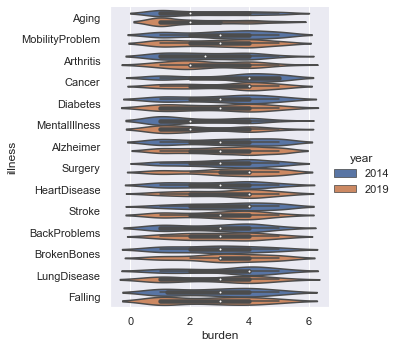

In [69]:
sns.set(rc={'figure.figsize':(20,20)})

sns.catplot(x="burden", y="illness",
            kind = 'violin', hue="year",
            data=data_burden)
plt.show()

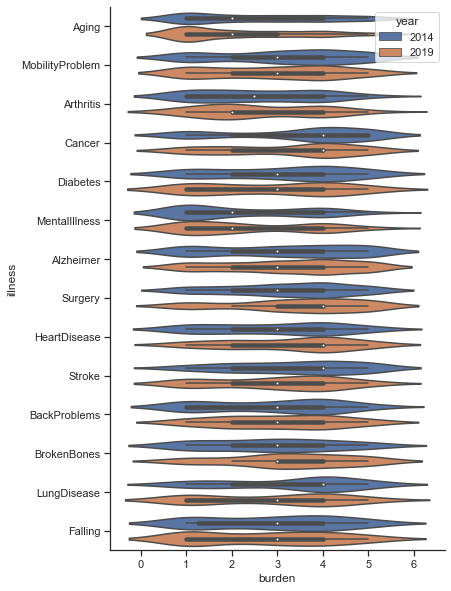

In [81]:
sns.set_style('ticks')
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(6, 10)
sns.violinplot(x="burden", y="illness",
            hue="year",
            data=data_burden)    
sns.despine()

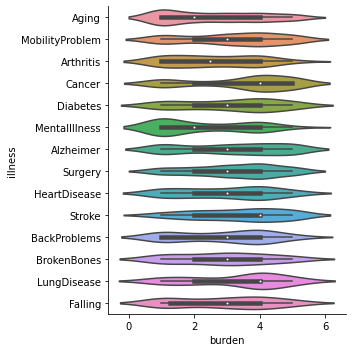

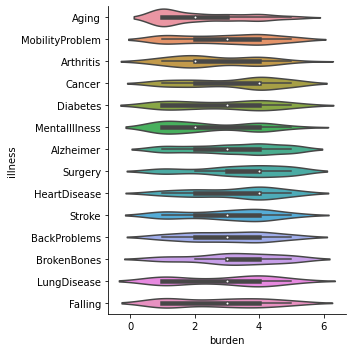

In [21]:
sns.catplot(x="burden", y="illness",
            kind="violin", data=data_2015)

sns.catplot(x="burden", y="illness",
            kind="violin", data=data_2020, order=["Aging", "MobilityProblem", "Arthritis", "Cancer", "Diabetes", "MentalIllness", "Alzheimer", "Surgery", "HeartDisease", "Stroke", "BackProblems", "BrokenBones", "LungDisease", "Falling"])

# 2014 vs 2019 Comparison

In [27]:
Aging = data_burden[data_burden['illness'] == 'Aging']
Aging

,year,illness,hours,adls,help_with_bed,help_with_dressed,help_with_bathe,help_with_med,help_with_toilet,iadls,giving_medicine,help_with_feeding,preparing_meals,live_with_cr,help_housework,help_with_diapers,burden
0,2014,Aging,28.0,0.0,No,No,No,No,No,4.0,No,No,Yes,Yes,Yes,No,3.0
27,2014,Aging,77.0,3.0,No,Yes,Yes,Yes,No,7.0,Yes,No,Yes,Yes,Yes,Yes,5.0
37,2014,Aging,77.0,6.0,Yes,Yes,Yes,Yes,Yes,7.0,Yes,Yes,Yes,Yes,Yes,Yes,5.0
42,2014,Aging,12.0,0.0,No,No,No,No,No,4.0,No,No,Yes,No,Yes,No,2.0
44,2014,Aging,0.5,0.0,No,No,No,No,No,2.0,No,No,No,Yes,Yes,No,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,2019,Aging,3.0,0.0,No,No,No,No,No,5.0,No,No,Yes,No,Yes,No,1.0
2516,2019,Aging,10.0,1.0,No,No,No,Yes,Yes,4.0,Yes,No,Yes,No,No,No,3.0
2519,2019,Aging,20.0,0.0,No,No,No,Yes,No,7.0,Yes,No,Yes,Yes,Yes,No,2.0
2526,2019,Aging,77.0,2.0,Yes,No,Yes,Yes,No,7.0,Yes,No,Yes,No,Yes,No,5.0


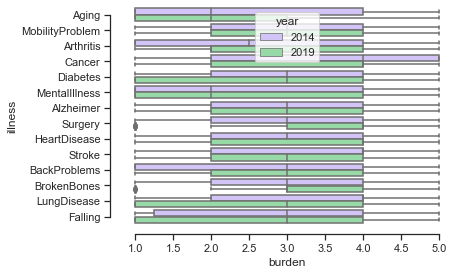

### Narrow Down Features

In [21]:
#Dropping features with small correlations
data_burden2 = data_burden.drop(['adls', 'help_housework', 'live_with_cr', 'preparing_meals', 'giving_medicine', 'help_with_med'], axis=1)

In [22]:
#Splitting the continuous variables and the categorical variables 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_cont2 = data_burden2.select_dtypes(include=numerics)
df_cat2 = data_burden2.select_dtypes(include = 'object')

#dummy coding the categorical variables
df_cat_dc2 = pd.get_dummies(df_cat2)
df_reg2 = pd.concat([df_cont2, df_cat_dc2], axis = 1)

In [23]:
#Helper function for 10-CV
# 10-Fold Cross Validation
def cross_validation (df, func):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = 10, shuffle = True, random_state = 10)
    kf_rmse = []
    
    for train, test in kf.split(df):
        X_train = df.iloc[train].loc[:, df.columns != 'burden']
        X_train = X_train.squeeze()
        X_test = df.iloc[test].loc[:, df.columns != 'burden']
        y_train = df.iloc[train].loc[:,'burden']
        y_test = df.iloc[test].loc[:,'burden']
        
        reg = func.fit(X_train, y_train)
        y_hat = reg.predict(X_test)
        
        from sklearn.metrics import mean_squared_error
        kf_rmse.append(mean_squared_error(y_test, y_hat, squared=False))
        
    kf_RMSE = (1/10) * np.sum(kf_rmse)
        
    return (kf_RMSE)

In [24]:
#Use 2014 data as train and 2020 data as test
X_train2 = df_reg2[df_reg2['year'] == 2014]
y_train2 = X_train2['burden']
X_train2 = X_train2.drop('burden', axis = 1)
df_train2 = pd.concat([X_train2, y_train2], axis=1, join='outer')

X_test2 = df_reg2[df_reg2['year'] == 2019]
y_test2 = X_test2['burden']
X_test2 = X_test2.drop('burden', axis = 1)

## Linear Regression with Narrowed Down Features

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [26]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()

model1.fit(X_train2, y_train2)

y_hat11 = model1.predict(X_test2)

score11 = np.mean(cross_val_score(estimator = model1, X = X_train2, y = y_train2, cv = 10))
model11_train_rmse = mean_squared_error(y_test2, y_hat11, squared=False)
model11_cv_rmse = cross_validation(df_reg2, model1)

print('test RMSE = ', model11_train_rmse)
print('10 CV RMSE = ', model11_cv_rmse)
print('score = ', score11)

test RMSE =  0.617294622740634
10 CV RMSE =  0.5908861018712251
score =  0.8358856466839193


Text(0, 0.5, 'Predicted Value')

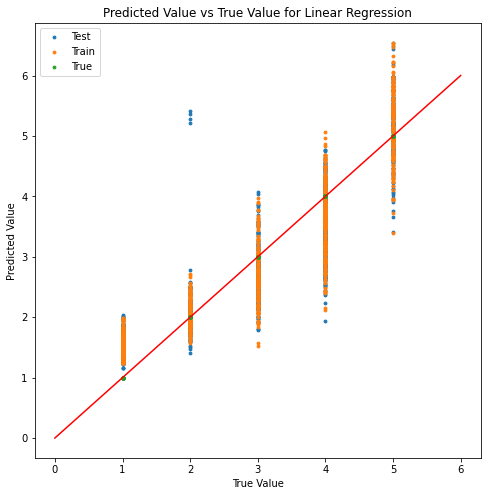

In [27]:
plt.figure(figsize = (8,8))
plt.scatter(x = y_test2, y = y_hat11, s = 8, label = "Test")
plt.scatter(x = y_train2, y = model1.predict(X_train2), s = 8, label = "Train")
plt.scatter(x = df_reg2['burden'], y = df_reg2['burden'], s = 8, label = "True")
plt.plot([0,6], [0,6], color = "r")
plt.legend(loc=0)
plt.title("Predicted Value vs True Value for Linear Regression")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

### Random Forest with Narrowed Down Features

In [28]:
randomForest = RandomForestRegressor(random_state = 0)
grid_para_forest = {'n_estimators': [100,500,1000,2500,5000],
'max_depth': [10,15,20,30,40,50],
'max_features' : [5,7,15]}
from sklearn.model_selection import GridSearchCV

grid_search_forest = GridSearchCV(randomForest, grid_para_forest, cv=10, n_jobs = 5, verbose=1)
grid_search_forest.fit(X_train2, y_train2)

model2_2 = grid_search_forest.best_estimator_
yhat_2_2 = model2_2.predict(X_test2)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [29]:
model2_2_train_rmse = mean_squared_error(y_test2, yhat_2_2, squared=False)
model2_2_cv_rmse = cross_validation(df_reg2, model2_2)
score2_2 = np.mean(cross_val_score(estimator = model2_2, X = X_train2, y = y_train2, cv = 10))

print('test RMSE = ', model2_2_train_rmse)
print('10 CV RMSE = ', model2_2_cv_rmse)
print('score = ', score2_2)

test RMSE =  0.21785316198581742
10 CV RMSE =  0.14716495125698706
score =  0.9905406122956115


Text(0, 0.5, 'Predicted Value')

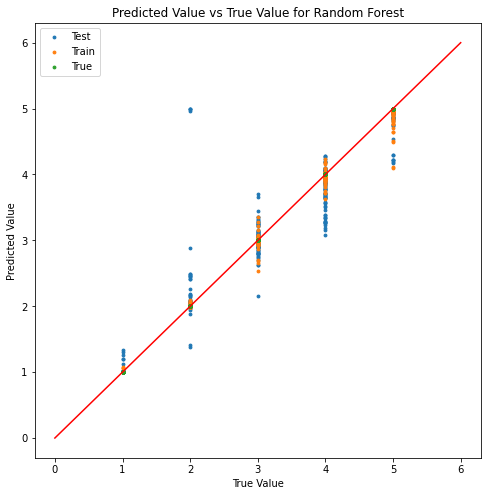

In [30]:
plt.figure(figsize = (8,8))
plt.scatter(x = y_test2, y = yhat_2_2, s = 8, label = "Test")
plt.scatter(x = y_train2, y = model2_2.predict(X_train2), s = 8, label = "Train")
plt.scatter(x = df_reg2['burden'], y = df_reg2['burden'], s = 8, label = "True")
plt.plot([0,6], [0,6], color = "r")
plt.legend(loc=0)
plt.title("Predicted Value vs True Value for Random Forest")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

Text(0, 0.5, 'Features')

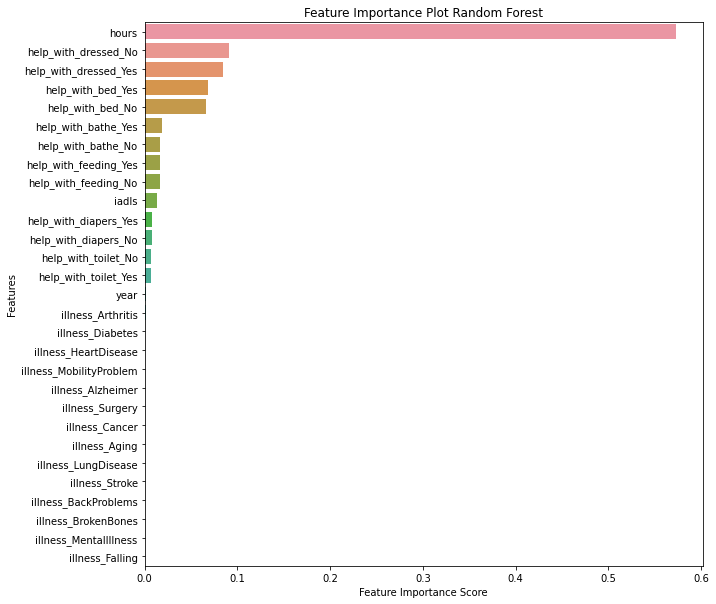

In [31]:
sorted_importance = sorted(zip(df_reg2.drop('burden', axis = 1).columns, model2_2.feature_importances_), key=lambda t:t[1], reverse = True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y='feature_name', orient = 'h');
plt.title('Feature Importance Plot Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

#### Run the Random Forest Again with Important Features

In [32]:
imp_cols = df[df['importance_score'] > 0.004]['feature_name'].tolist()

In [33]:
grid_search_forest.fit(X_train2[imp_cols], y_train2)

model22_2 = grid_search_forest.best_estimator_
yhat_22_2 = model22_2.predict(X_test2[imp_cols])

Fitting 10 folds for each of 90 candidates, totalling 900 fits


c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
300 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\Woon.Kim\Anaconda33\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Woon.Kim\Anaconda

In [34]:
model22_2_train_rmse = mean_squared_error(y_test2, yhat_22_2, squared=False)
model22_2_cv_rmse = cross_validation(df_reg2, model22_2)
score22_2 = np.mean(cross_val_score(estimator = model22_2, X = X_train2, y = y_train2, cv = 10))

print('test RMSE = ', model22_2_train_rmse)
print('10 CV RMSE = ', model22_2_cv_rmse)
print('score = ', score22_2)

test RMSE =  0.2139092728456291
10 CV RMSE =  0.16364841502057426
score =  0.98692916992529


Text(0, 0.5, 'Predicted Value')

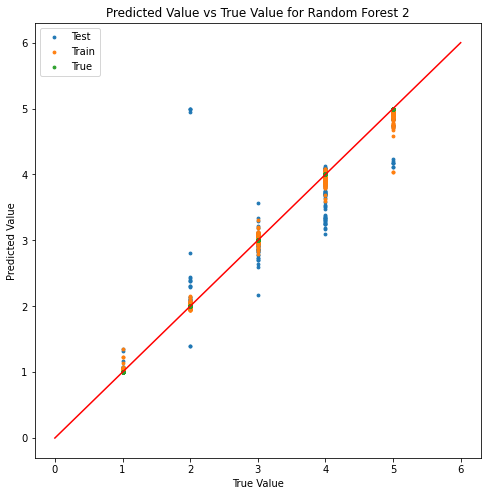

In [35]:
plt.figure(figsize = (8,8))
plt.scatter(x = y_test2, y = yhat_22_2, s = 8, label = "Test")
plt.scatter(x = y_train2, y = model22_2.predict(X_train2), s = 8, label = "Train")
plt.scatter(x = df_reg2['burden'], y = df_reg2['burden'], s = 8, label = "True")
plt.plot([0,6], [0,6], color = "r")
plt.legend(loc=0)
plt.title("Predicted Value vs True Value for Random Forest 2")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Gradient Boost

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state = 0)

In [37]:
grid_para_gb = {'n_estimators': [100,500,1000,2500,5000],
                   'learning_rate':[0.01,0.05,0.1],
                   'max_depth':range(1,6),
                   'max_features' : [5,7,15]}

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
grid_search_gb = GridSearchCV(gbm, grid_para_gb, cv=5, n_jobs = 5, verbose = 1)
grid_search_gb.fit(X_train2, y_train2)


Fitting 5 folds for each of 225 candidates, totalling 1125 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': range(1, 6), 'max_features': [5, 7, 15],
                         'n_estimators': [100, 500, 1000, 2500, 5000]},
             verbose=1)

In [39]:
model3 = grid_search_gb.best_estimator_
yhat_3 = model3.predict(X_test2)

In [51]:
model3_train_rmse = mean_squared_error(y_test2, yhat_3, squared=False)
model3_cv_rmse = cross_validation(df_reg2, model3)
score3 = np.mean(cross_val_score(estimator = model3, X = X_train2, y = y_train2, cv = 10))

print('train RMSE = ', model3_train_rmse)
print('10 CV RMSE = ', model3_cv_rmse)
print('score = ', score3)

train RMSE =  0.21674346746276216
10 CV RMSE =  0.171790243532446
score =  0.9908105163651229


Text(0, 0.5, 'Predicted Value')

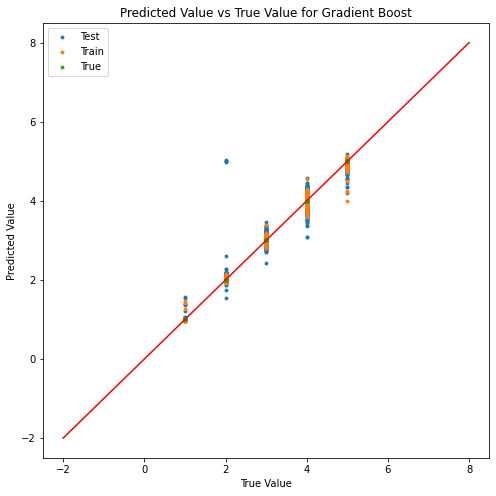

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(x = y_test2, y = yhat_3, s = 8, label = "Test")
plt.scatter(x = y_train2, y = model3.predict(X_train2), s = 8, label = "Train")
plt.scatter(x = df_reg2['burden'], y = df_reg2['burden'], s = 8, label = "True")
plt.plot([-2,8],[-2,8], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Gradient Boost")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

Text(0, 0.5, 'Features')

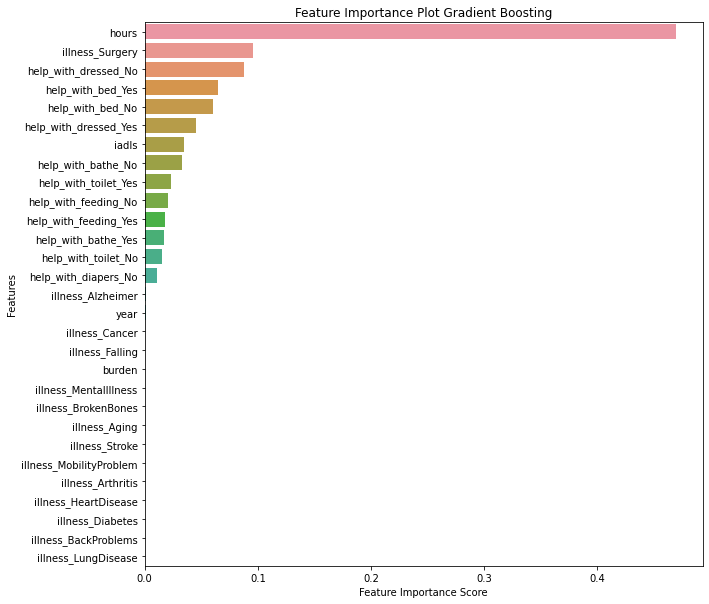

In [43]:
sorted_importance = sorted(zip(df_reg2.columns, model3.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Plot Gradient Boosting')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

In [44]:
imp_cols = df[df['importance_score'] > 0.004]['feature_name'].tolist()

In [45]:
grid_search_gb.fit(X_train2[imp_cols], y_train2)

model33 = grid_search_gb.best_estimator_
yhat_33 = model33.predict(X_test2[imp_cols])

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
375 fits failed out of a total of 1125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
375 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\ensemble\_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "c:\Users\Woon.Kim\Anaconda33\lib\site-packages\sklearn\ensemble\_gb.py", line 663, in _fit_stages
    raw_predictions = self._fit_stage(
  File "c:\Users\Woon.

In [46]:
model33_train_rmse = mean_squared_error(y_test2, yhat_33, squared=False)
model33_cv_rmse = cross_validation(df_reg2, model33)
score33 = np.mean(cross_val_score(estimator = model33, X = X_train2, y = y_train2, cv = 10))

print('train RMSE = ', model33_train_rmse)
print('10 CV RMSE = ', model33_cv_rmse)
print('score = ', score33)

train RMSE =  0.2101128480738285
10 CV RMSE =  0.1787693104808365
score =  0.9891015021474979


Text(0, 0.5, 'Predicted Value')

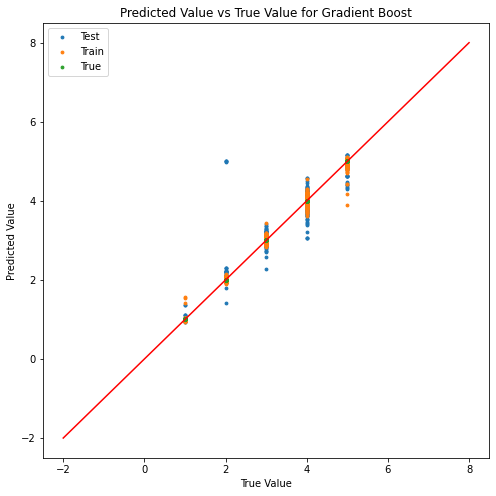

In [48]:
plt.figure(figsize=(8,8))
plt.scatter(x = y_test2, y = yhat_33, s = 8, label = "Test")
plt.scatter(x = y_train2, y = model33.predict(X_train2), s = 8, label = "Train")
plt.scatter(x = df_reg2['burden'], y = df_reg2['burden'], s = 8, label = "True")
plt.plot([-2,8],[-2,8], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Gradient Boost")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

### RMSE Summary

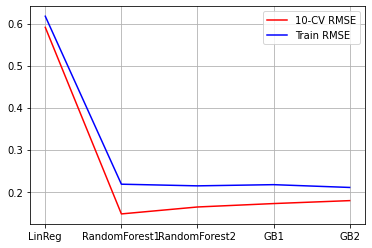

In [49]:
x = ['LinReg', 'RandomForest1', 'RandomForest2', 'GB1', 'GB2']
y1 = [model11_train_rmse, model2_2_train_rmse, model22_2_train_rmse, model3_train_rmse, model33_train_rmse]
y2 = [model11_cv_rmse, model2_2_cv_rmse, model22_2_cv_rmse, model3_cv_rmse, model33_cv_rmse]

plt.plot(x, y2, label = "10-CV RMSE", c='r')
plt.plot(x, y1, label = "Train RMSE", c='b')
plt.legend()
plt.grid()
plt.show()

## Score Summary

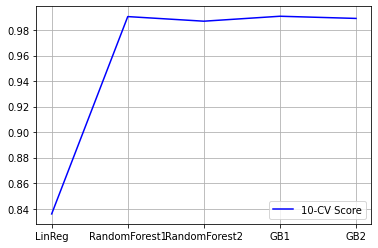

In [52]:
x = ['LinReg', 'RandomForest1', 'RandomForest2', 'GB1', 'GB2']
y1 = [score11, score2_2, score22_2, score3, score33]

plt.plot(x, y1, label = "10-CV Score", c='b')
plt.legend()
plt.grid()
plt.show()